In [1]:
import sys
sys.path.insert(0,'/home/djl34/kl_git/scripts')
from notebook_imports import *
import einops

client = Client()

/home/djl34/mambaforge/envs/raklette/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
/home/djl34/mambaforge/envs/raklette/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34837 instead
  warnings.warn(


# Try for chromosome 22

In [2]:
chrom = 22
filename = os.path.join(KL_data_dir, f"whole_genome/p/{chrom}/_metadata")
rate = dd.read_parquet(filename.split("_metadata")[0])

In [3]:
rate.head()

/home/djl34/mambaforge/envs/raklette/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


,Pos,mu,Allele_ref,Allele,mu_index,AN_total_interpolate,AC_total,filter_int,AF_gnomADv3,AF_ukb,AF,window_100bp,polymorphic,polymorphic_100bp,Neutral,cds,Freq_bin_9,Freq_bin_10,p_9,E[p_9],Var[p_9],p_2,E[p_2],Var[p_2]
0,11253100,2.659,G,A,49,1135310.0,93.0,4,0.00021,0.000062,8.191595e-05,0,1,122,NaN,False,6,6,-0.892526,-0.624098,0.070286,-1.000000,-0.996884,0.003096
1,11253100,0.128,G,T,11,1135225.0,0.0,4,NaN,NaN,0.000000e+00,0,0,122,NaN,False,0,0,-0.712308,-0.765350,0.007888,-0.712308,-0.795075,0.016961
2,11253101,0.041,T,A,3,1135225.0,2.0,4,NaN,0.000002,1.761765e-06,0,1,122,NaN,False,2,2,-0.965165,-0.905086,0.000443,-1.000000,-0.908619,0.000946
3,11253101,0.041,T,G,3,1135225.0,1.0,4,NaN,0.000001,8.808826e-07,0,1,122,NaN,False,1,1,-0.949767,-0.905086,0.000443,-1.000000,-0.908619,0.000946
4,11253101,0.117,T,C,10,1135140.0,22970.0,4,0.02586,0.019366,2.023539e-02,0,1,122,NaN,False,8,8,-1.000000,-0.779518,0.006429,-1.000000,-0.804747,0.013817


In [4]:
rate_neutral = rate[~rate["Neutral"].isna()].compute()
rate_neutral = rate_neutral.reset_index(drop = True)

## Group by 50 sites and calculate zscore

Histogram plot shows that it is normally distributed

In [8]:
rate_neutral_groups = rate_neutral.groupby(np.arange(len(rate_neutral.index))//50)

rate_neutral_groups_sum = rate_neutral_groups[["p_9", "E[p_9]", "Var[p_9]", "p_2", "E[p_2]", "Var[p_2]"]].sum()

# remove last column, since it has less than 50 sites
rate_neutral_groups_sum = pd.DataFrame(rate_neutral_groups_sum).iloc[:-1]

for freq_bin in [2, 9]:
    rate_neutral_groups_sum[f"Zscore_{freq_bin}"] = ((rate_neutral_groups_sum[f"p_{freq_bin}"] - rate_neutral_groups_sum[f"E[p_{freq_bin}]"])/
                                                np.sqrt(rate_neutral_groups_sum[f"Var[p_{freq_bin}]"]))

freq_bin = 2
rate_neutral_groups_sum["Zscore_Gnocchi"] = ((rate_neutral_groups_sum[f"p_{freq_bin}"] - rate_neutral_groups_sum[f"E[p_{freq_bin}]"])/
                                                np.sqrt(np.absolute(rate_neutral_groups_sum[f"E[p_{freq_bin}]"])))

rate_neutral_groups_sum_zscore = pd.melt(rate_neutral_groups_sum, value_vars=['Zscore_2', 'Zscore_9', "Zscore_Gnocchi"], value_name = "Zscore", var_name = "type")

In [10]:
rate_neutral_groups_sum[["Zscore_2", "Zscore_9", "Zscore_Gnocchi"]].mean()

Zscore_2         -0.019239
Zscore_9         -0.029205
Zscore_Gnocchi   -0.002590
dtype: float64

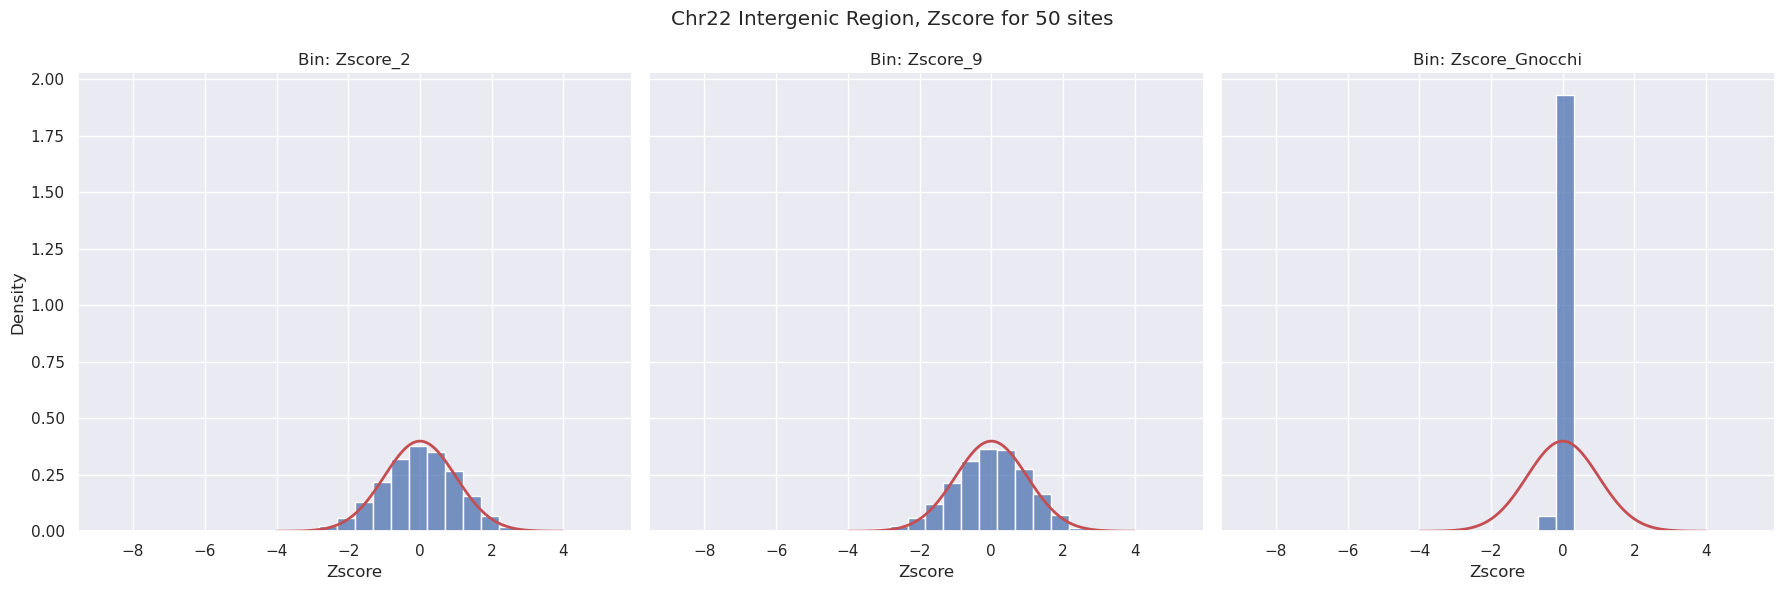

In [11]:
sns.set_theme(style="darkgrid")
g = sns.FacetGrid(rate_neutral_groups_sum_zscore, col="type", height=6, margin_titles=True)

g.map(sns.histplot, "Zscore", binwidth=0.5, kde=False, stat='density', label='samples')

g.set_titles(col_template="Bin: {col_name}")
# g.set_titles(col_template="Mu: {col_name}", row_template="window length: {row_name}")

g.fig.suptitle('Chr22 Intergenic Region, Zscore for 50 sites')

def standard_normal(*args, **kwargs):
    # x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(-4, 4, 100)
    y_pdf = scipy.stats.norm.pdf(x_pdf)

    plt.plot(x_pdf, y_pdf, 'r', lw=2, label='pdf')   

g.map(standard_normal)

In [15]:
n_sites = 10000
rate_neutral_groups = rate_neutral.groupby(np.arange(len(rate_neutral.index))//n_sites)

rate_neutral_groups_sum = rate_neutral_groups[["p_9", "E[p_9]", "Var[p_9]", "p_2", "E[p_2]", "Var[p_2]"]].sum()

# remove last column, since it has less than 50 sites
rate_neutral_groups_sum = pd.DataFrame(rate_neutral_groups_sum).iloc[:-1]

for freq_bin in [2, 9]:
    rate_neutral_groups_sum[f"Zscore_{freq_bin}"] = ((rate_neutral_groups_sum[f"p_{freq_bin}"] - rate_neutral_groups_sum[f"E[p_{freq_bin}]"])/
                                                np.sqrt(rate_neutral_groups_sum[f"Var[p_{freq_bin}]"]))

freq_bin = 2
rate_neutral_groups_sum["Zscore_Gnocchi"] = ((rate_neutral_groups_sum[f"p_{freq_bin}"] - rate_neutral_groups_sum[f"E[p_{freq_bin}]"])/
                                                np.sqrt(np.absolute(rate_neutral_groups_sum[f"E[p_{freq_bin}]"])))

rate_neutral_groups_sum_zscore = pd.melt(rate_neutral_groups_sum, value_vars=['Zscore_2', 'Zscore_9', "Zscore_Gnocchi"], value_name = "Zscore", var_name = "type")

In [16]:
rate_neutral_groups_sum[["Zscore_2", "Zscore_9", "Zscore_Gnocchi"]].mean()

Zscore_2         -0.298442
Zscore_9         -0.501419
Zscore_Gnocchi   -0.036771
dtype: float64

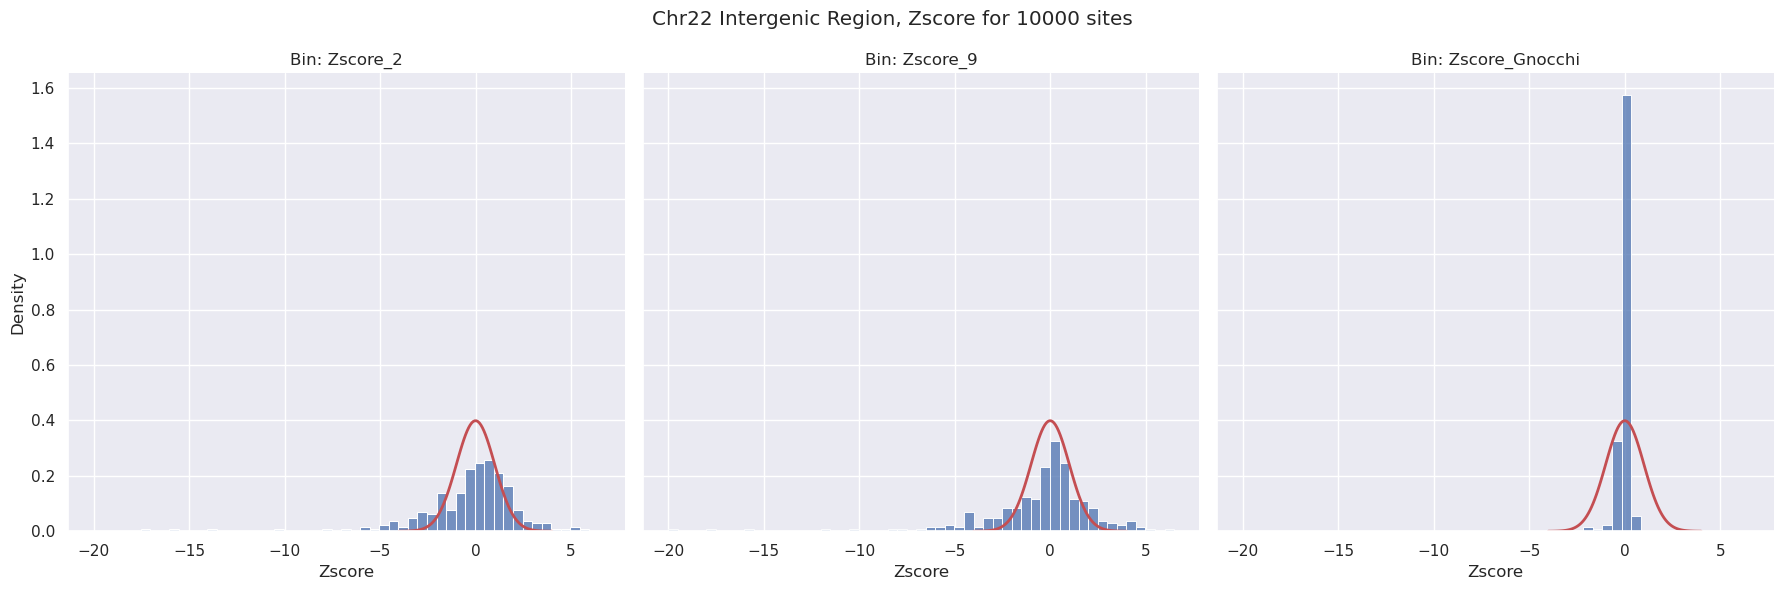

In [17]:
sns.set_theme(style="darkgrid")
g = sns.FacetGrid(rate_neutral_groups_sum_zscore, col="type", height=6, margin_titles=True)

g.map(sns.histplot, "Zscore", binwidth=0.5, kde=False, stat='density', label='samples')

g.set_titles(col_template="Bin: {col_name}")
# g.set_titles(col_template="Mu: {col_name}", row_template="window length: {row_name}")

g.fig.suptitle(f'Chr22 Intergenic Region, Zscore for {n_sites} sites')

def standard_normal(*args, **kwargs):
    # x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(-4, 4, 100)
    y_pdf = scipy.stats.norm.pdf(x_pdf)

    plt.plot(x_pdf, y_pdf, 'r', lw=2, label='pdf')   

g.map(standard_normal)

## Quantile Quantile Plot

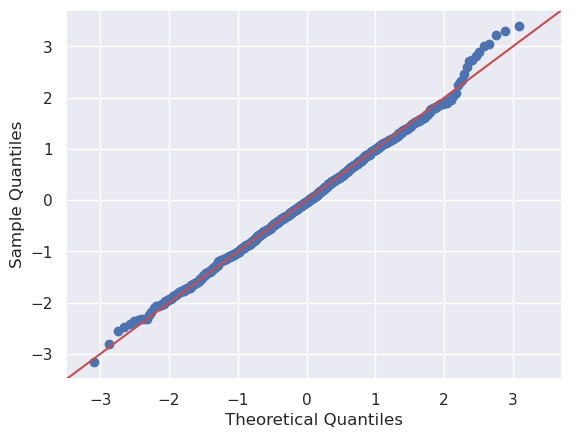

In [11]:
import numpy as np
import statsmodels.api as sm
import pylab

test = np.random.normal(0,1, 1000)

sm.qqplot(test, line='45')
pylab.show()

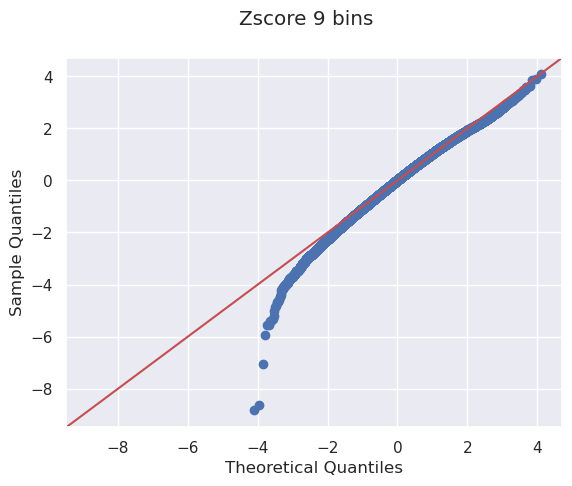

In [25]:
fig = sm.qqplot(rate_neutral_groups_sum["Zscore_9"], line='45')

fig.suptitle("Zscore 9 bins")

pylab.show()

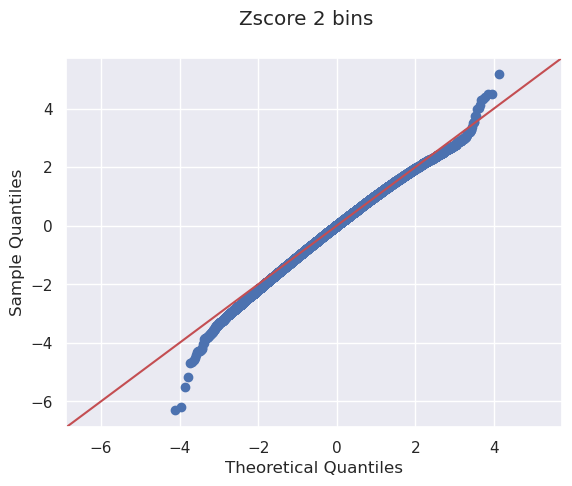

In [27]:
fig = sm.qqplot(rate_neutral_groups_sum["Zscore_2"], line='45')

fig.suptitle("Zscore 2 bins")
pylab.show()

## get outliers

In [33]:
index = rate_neutral_groups_sum.sort_values("Zscore_9").iloc[0:5].index

In [36]:
rate_neutral["region"] = np.arange(len(rate_neutral.index))//50

In [40]:
rate_neutral[rate_neutral["region"].isin(index)].to_csv("neutral_chr22_outlier.tsv", sep = "\t", index = None)

# Try for chromosome 3

In [3]:
chrom = 3
filename = os.path.join(scratch_dir, f"whole_genome/p_9/{chrom}/_metadata")
rate = dd.read_parquet(filename.split("_metadata")[0])

In [5]:
for freq_bin in [9]:
    rate[f"Zscore_{freq_bin}"] = ((rate[f"p_{freq_bin}"] - rate[f"E[p_{freq_bin}]"])/
                                                np.sqrt(rate[f"Var[p_{freq_bin}]"]))


In [6]:
rate.head()

,Pos,mu,Allele_ref,Allele,mu_index,AN_total_interpolate,AC_total,filter_int,AF_gnomADv3,AF_ukb,AF,window_100bp,polymorphic,polymorphic_100bp,Neutral,cds,Freq_bin_9,Freq_bin_10,p_9,E[p_9],Var[p_9],Zscore_9
0,12200,0.041,A,C,3,1135038.0,1.0,3,0.000007,NaN,8.810278e-07,0,1,90,NaN,False,1,1,-0.949767,-0.905086,0.000443,-2.122215
1,12200,0.020,A,T,1,1134263.0,0.0,3,NaN,NaN,0.000000e+00,0,0,90,NaN,False,0,0,-0.946241,-0.948165,0.000070,0.230569
2,12200,0.094,A,G,8,1134263.0,0.0,3,NaN,NaN,0.000000e+00,0,0,90,NaN,False,0,0,-0.777523,-0.809592,0.003986,0.507928
3,12201,0.083,A,G,7,1134263.0,1.0,4,NaN,0.000001,8.816297e-07,0,1,90,NaN,False,1,1,-0.897107,-0.826126,0.002978,-1.300691
4,12201,0.013,A,T,0,1134263.0,0.0,4,NaN,NaN,0.000000e+00,0,0,90,NaN,False,0,0,-0.965322,-0.966130,0.000019,0.183913


In [3]:
rate_neutral = rate[~rate["Neutral"].isna()].compute()
rate_neutral = rate_neutral.reset_index(drop = True)

/home/djl34/mambaforge/envs/raklette/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
2024-05-22 00:26:27,754 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('getitem-b89998a7aff62cc199d4d62c99f91de4', 30))" coro=<Worker.execute() done, defined at /home/djl34/mambaforge/envs/raklette/lib/python3.9/site-packages/distributed/worker_state_machine.py:3610>> ended with CancelledError


KeyboardInterrupt: 

Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/home/djl34/mambaforge/envs/raklette/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/djl34/mambaforge/envs/raklette/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/djl34/mambaforge/envs/raklette/lib/python3.9/site-packages/distributed/process.py", line 202, in _run
    target(*args, **kwargs)
  File "/home/djl34/mambaforge/envs/raklette/lib/python3.9/site-packages/distributed/nanny.py", line 1014, in _run
    asyncio_run(run(), loop_factory=get_loop_factory())
  File "/home/djl34/mambaforge/envs/raklette/lib/python3.9/site-packages/distributed/compatibility.py", line 236, in asyncio_run
    return loop.run_until_complete(main)
  File "/home/djl34/mambaforge/envs/raklette/lib/python3.9/asyncio/base_events.py", line 634, in run_until_complete
    self.run_forever()
  File "/home/djl34/m